<center><h1>Fluorescence Simulation</h1></center>


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm import tqdm
import scipy.stats as stats


from photophysics import apply_photoswitching_one_molecule, count_cycles_per_frame
from photons_stats import study_stats

# A Discrete-Time Markov Chain

To describe tranisitions between quantum states, we use a discrete-time Markov chain. It means that, for each molecule,  we will use a time discretisation $t_n \, \forall n \in \{0,...,N\}$.

We will fix in seconds:

$$
t_{n+1} -t_n = \delta
$$

This $\delta$, describes  the time grid in which the quantum dynamics occur. We will fix $\delta = 10^{-7}s$.

We define thus the Markov chain on this time grid and in  the state space of quantum states as $$\{X_n = X(t_n)\}_{n=0}^N$$


The transition is governed by the tranisiton matrix P that we will detail later.

In [2]:
def simulate_one_molecule(time_points, trans_p,initial_state,time_discret, exposure_time, num_frames, scheme="STORM",plot_evolution=True, plot_photons=True, compute_emission=True, molecule_index = 0):
    molecule_states,bleaching_time = apply_photoswitching_one_molecule(time_points, trans_p,initial_state, scheme)
    
    if plot_evolution:

        # Plot the state evolution over time
        time_axis = np.arange(molecule_states.shape[0]) * time_discret



        plt.figure(figsize=(10, 5))
        plt.plot(time_axis, molecule_states, marker='o')
        for n in range(num_frames):
            plt.axvline(x=n*exposure_time,color='red',linewidth=0.5)
        plt.xlabel('Time Point (s) ')
        plt.ylabel('State')
        plt.title(f'{scheme} evolution ')
        if scheme=='PALM':
            plt.yticks([-1,0,1, 2,3], ['NA','S0', 'S1', 'T1', 'bleached' ])
        else:
            plt.yticks([0,1, 2,3], ['S0', 'S1', 'T1', 'bleached' ])
        plt.grid(True)
        plt.savefig(f"Output plot/{scheme}/molecule_{molecule_index}.png")
        plt.show()

    if compute_emission :
        photon_emissions_per_frame = count_cycles_per_frame(molecule_states,time_points, num_frames)

        if plot_photons:
            # Plotting the results as a bar plot
            frames = np.arange(len(photon_emissions_per_frame))
            plt.figure(figsize=(10, 5))
            plt.bar(frames, photon_emissions_per_frame)
            plt.xlabel('Frame')
            plt.ylabel('Number of cycles ON')
            plt.title(f'Number of cycles Per Frame in {scheme}')
            plt.grid(True)
            plt.savefig(f"Output plot/{scheme}/photon_{molecule_index}.png")
            plt.show()
        
        return molecule_states, bleaching_time,photon_emissions_per_frame
    
    else: 
        return molecule_states, bleaching_time

## STROM Protocol


<img src="img/STROM.png" alt="STORM" style="width:400px;height:auto;"/>

 
* STORM requires the use of fluorophores capable of transitioning between prolonged (in the order of millisecond) emitting ‘on’ and non-emitting ‘off’  until eventually the fluorophore enters an irreversible photobleached state
* Since only a small fraction of the total fluorophores are emitting, it is imperative to acquire **several thousands of frames** of the observed field.
* the probability of the fluorophore to transition between the ‘on’ and the ‘off’ state can be optimised to the frame acquisition rate.
* The need for high-power laser illumination (from ∼62 to 7.8 kW/cm2)

<br>

* Start would be in T1

<br>

* We consider the transition matrix in STORM in this form 

$$
\begin{pmatrix}
0 & p_{\text{on } 0}   & 0 & 0 &0    \\
0 & p_{00} &p_{01}  & 0 & 0    \\
0 & p_{10}  & p_{11} & p_{1T} & p_{1B}     \\
0 & p_{0T}  & 0 & p_{TT} & 0     \\
0 & 0  & 0 & 0 & 1    \\
\end{pmatrix}
$$

where $ p_{ij} = \mathbb{P}(X(t_{n+1}) = j | X(t_{n}) = i )$



* Considering this time discretization $\delta = 10^{-7}s$, we will consider that the transition $S_1 \rightarrow S_0$ and $S_1 \rightarrow T$ is very fast so the probability $p_{11} = 0$ 
* We don't consider the activation probability $p_{\text{on }0} = 1 $


In [3]:
num_frames =361
exposure_time = 2e-2 #s

experiment_duration = num_frames*exposure_time #s
time_discret =1e-6 #s

time_points = int(experiment_duration//time_discret) # points

In [4]:
time_points

7220000

These probabilities were empirically determined to best approximate the physical transitions. Implicitly, these probabilities are proportional to the number of discrete time points.

In [5]:
p_on_0=1

p_0_1 = 0.004
p_0_T = 0
p_0_bleach = 0

p_1_0 = 0.8
p_1_T = 3e-4
p_1_bleach = 7e-4

p_T_0 = 3e-6
p_T_1 = 0
p_T_bleach = 0


trans_p_storm = np.array([
    [1-p_on_0,p_on_0,0,0,0],
    [0,1-(p_0_1 +p_0_T), p_0_1 , p_0_T, p_0_bleach],
    [0,1-(p_1_T+p_1_bleach), 0, p_1_T, p_1_bleach ],
    [0,p_T_0, p_T_1, 1-(p_T_0 + p_T_1+p_T_bleach), p_T_bleach],
    [0, 0, 0, 0, 1]
])

trans_p_storm 

array([[0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 9.96000e-01, 4.00000e-03, 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 9.99000e-01, 0.00000e+00, 3.00000e-04, 7.00000e-04],
       [0.00000e+00, 3.00000e-06, 0.00000e+00, 9.99997e-01, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]])

We will now simulate the behavior of 2 different molecules. We will plot:

1. The transition between the quantum states 
2. The number of cycles in each frame that corresponds to the number of photons per frame
3. The transition between the states in one frame

molecule 1


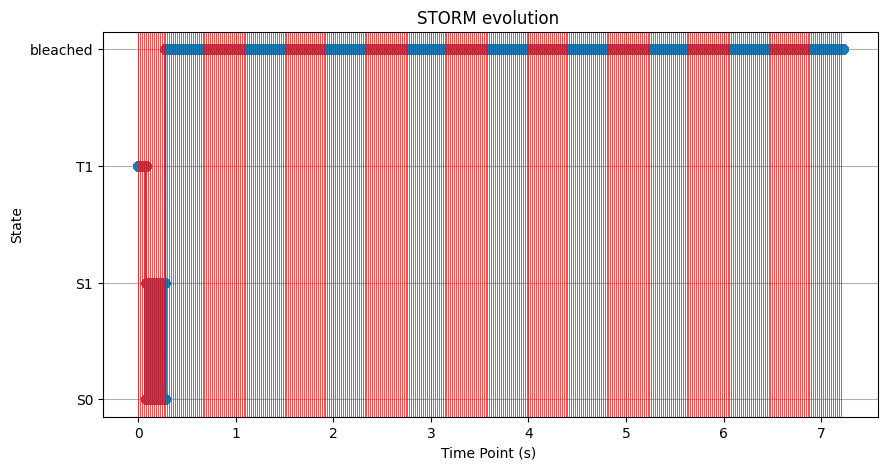

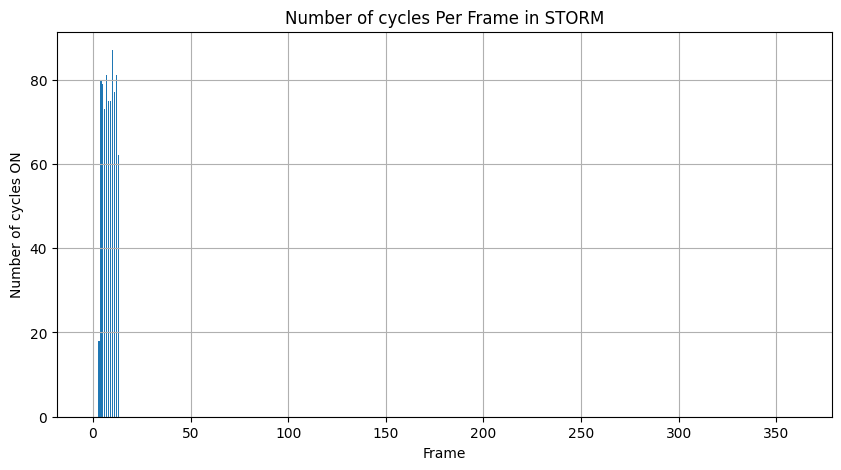

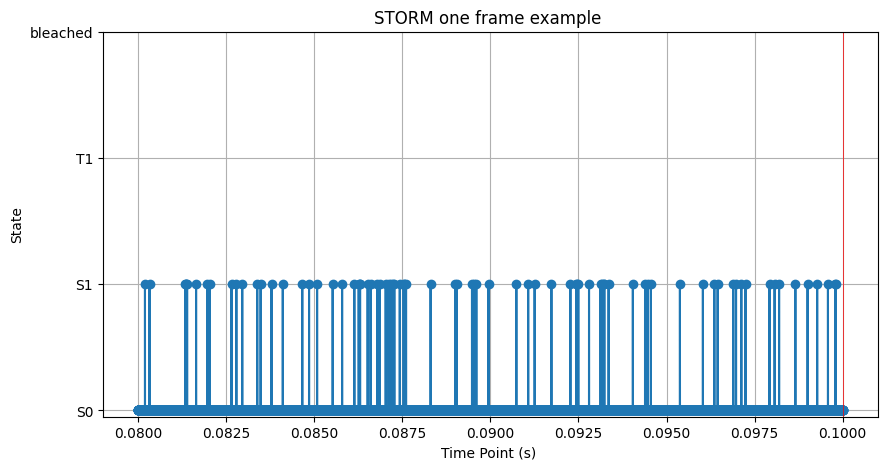

molecule 2


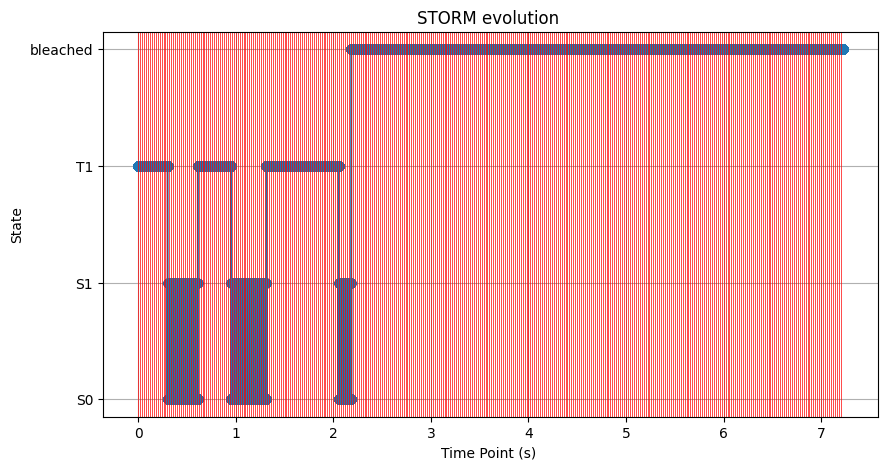

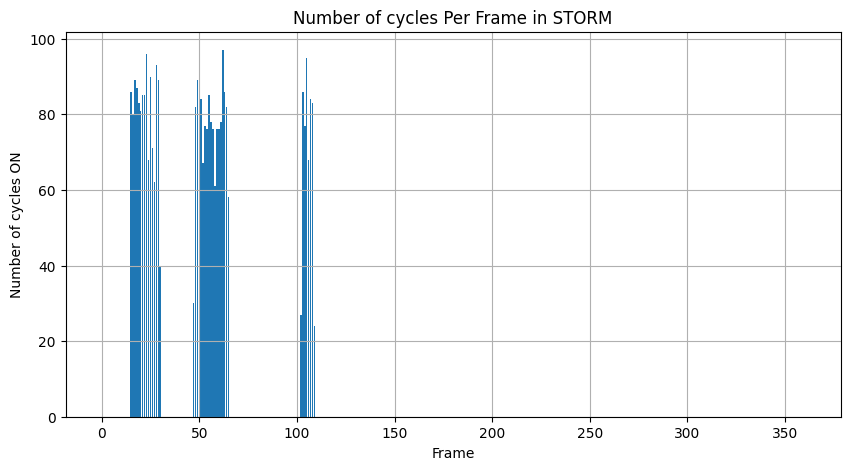

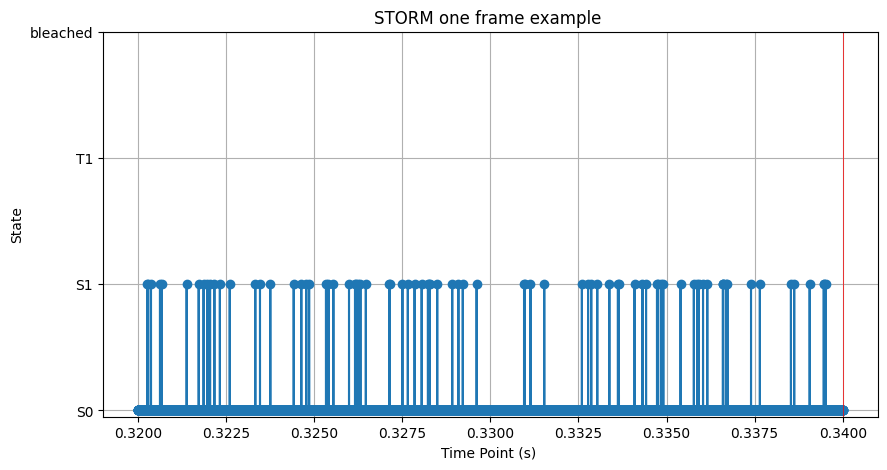

In [6]:
np.random.seed(123)

many_molecules_states =[]
for i in range(2):

    print("molecule", i+1)
    molecule_states_storm, bt,photon_count_strom = simulate_one_molecule(time_points, trans_p_storm,2,time_discret, exposure_time, num_frames, scheme="STORM",plot_evolution=True, plot_photons=True, compute_emission=True)
    n = int((np.where(photon_count_strom != 0)[0][1])*exposure_time/time_discret)
    time_axis = np.arange(n,n+int(exposure_time/time_discret)) * time_discret
    plt.figure(figsize=(10, 5))
    plt.plot(time_axis, molecule_states_storm[n:n+int(exposure_time/time_discret)], marker='o')
    plt.axvline(x=(n+int(exposure_time/time_discret)) * time_discret,color='red',linewidth=0.5)
    plt.xlabel('Time Point (s) ')
    plt.ylabel('State')
    plt.title(f'STORM one frame example ')
    plt.yticks([0,1, 2,3], ['S0', 'S1', 'T1', 'bleached' ])
    plt.grid(True)
    plt.savefig(f"Output plot/STORM/molecule_{i+1}_zoom.png")
    plt.show()  

    

Here, we study the distribution of the photon emissions per frame for one molecule


Comparison Metrics:
normal - Log Likelihood: -183.40, AIC: 370.79, BIC: 374.32, KL Divergence: 0.62, EMD: 9.23
laplace - Log Likelihood: -177.08, AIC: 358.16, BIC: 361.68, KL Divergence: 0.45, EMD: 5.18
poisson - Log Likelihood: -232.74, AIC: 467.47, BIC: 469.24, KL Divergence: 0.79, EMD: 7.16
geometric - Log Likelihood: -228.97, AIC: 459.94, BIC: 461.70, KL Divergence: 1.26, EMD: 47.81
binomial - Log Likelihood: -452.78, AIC: 909.57, BIC: 913.09, KL Divergence: 0.77, EMD: 9.91


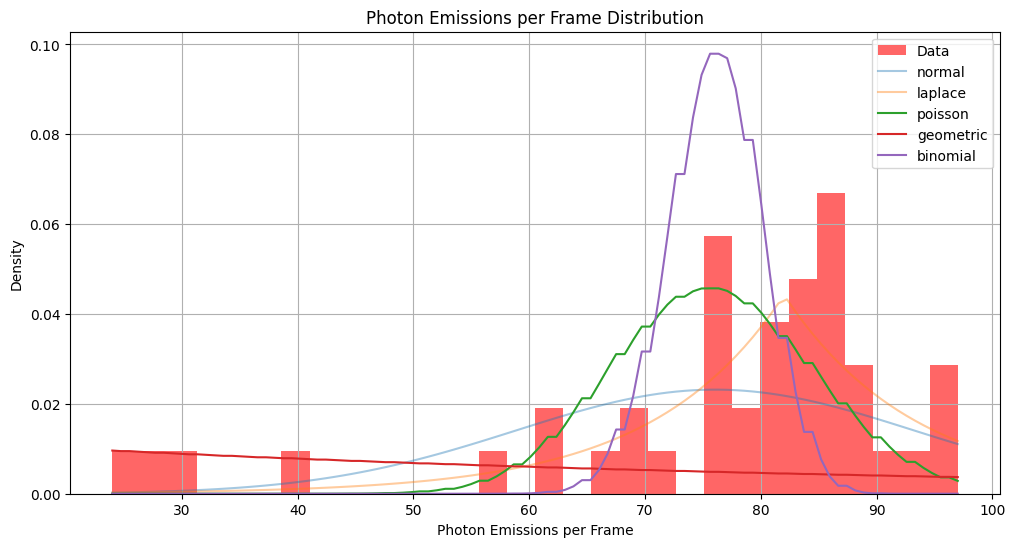

In [14]:
study_stats(photon_count_strom[photon_count_strom!=0], distributions = {'normal': stats.norm,
                                 'laplace': stats.laplace,
                                 'geometric': stats.geom,
                                 'poisson': stats.poisson, 'binomial': stats.binom},plot_distribution = True,
                verbose_distribution = True)

## PALM Protocol


<img src="img/PALM.png" alt="STORM" style="width:400px;height:auto;"/>

 
* STORM requires the use of fluorophores capable of transitioning between prolonged (in the order of millisecond) emitting ‘on’ and non-emitting ‘off’  until eventually the fluorophore enters an irreversible photobleached state
* Since only a small fraction of the total fluorophores are emitting, it is imperative to acquire **several thousands of frames** of the observed field.
* the probability of the fluorophore to transition between the ‘on’ and the ‘off’ state can be optimised to the frame acquisition rate.
* The need for high-power laser illumination (from ∼62 to 7.8 kW/cm2)

<br>

* Start would be in T1

<br>

* We consider the transition matrix in STORM in this form 

$$
\begin{pmatrix}
0 & p_{\text{on } 0}   & 0 & 0 &0    \\
0 & p_{00} &p_{01}  & 0 & 0    \\
0 & p_{10}  & p_{11} & p_{1T} & p_{1B}     \\
0 & p_{0T}  & 0 & p_{TT} & 0     \\
0 & 0  & 0 & 0 & 1    \\
\end{pmatrix}
$$

where $ p_{ij} = \mathbb{P}(X(t_{n+1}) = j | X(t_{n}) = i )$



* Considering this time discretization $\delta = 10^{-7}s$, we will consider that the transition $S_1 \rightarrow S_0$ and $S_1 \rightarrow T$ is very fast so the probability $p_{11} = 0$ 
* We don't consider the activation probability $p_{\text{on }0} = 1 $


In [25]:
num_frames =361
exposure_time = 2e-2 #s

experiment_duration = num_frames*exposure_time #s
time_discret =1e-6 #s

time_points = int(experiment_duration//time_discret) # points

In [26]:
time_points

7220000

These probabilities were empirically determined to best approximate the physical transitions. Implicitly, these probabilities are proportional to the number of discrete time points.

In [31]:
p_on_0=1e-6

p_0_1 = 0.009
p_0_T = 0
p_0_bleach = 0

p_1_0 = 0.8
p_1_T = 0
p_1_bleach = 5e-4

p_T_0 = 3e-6
p_T_1 = 0
p_T_bleach = 0


trans_p_palm= np.array([
    [1-p_on_0,p_on_0,0,0,0],
    [0,1-(p_0_1 +p_0_T), p_0_1 , p_0_T, p_0_bleach],
    [0,1-(p_1_T+p_1_bleach), 0, p_1_T, p_1_bleach ],
    [0,p_T_0, p_T_1, 1-(p_T_0 + p_T_1+p_T_bleach), p_T_bleach],
    [0, 0, 0, 0, 1]
])

trans_p_palm

array([[9.99999e-01, 1.00000e-06, 0.00000e+00, 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 9.91000e-01, 9.00000e-03, 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 9.99500e-01, 0.00000e+00, 0.00000e+00, 5.00000e-04],
       [0.00000e+00, 3.00000e-06, 0.00000e+00, 9.99997e-01, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]])

molecule 1


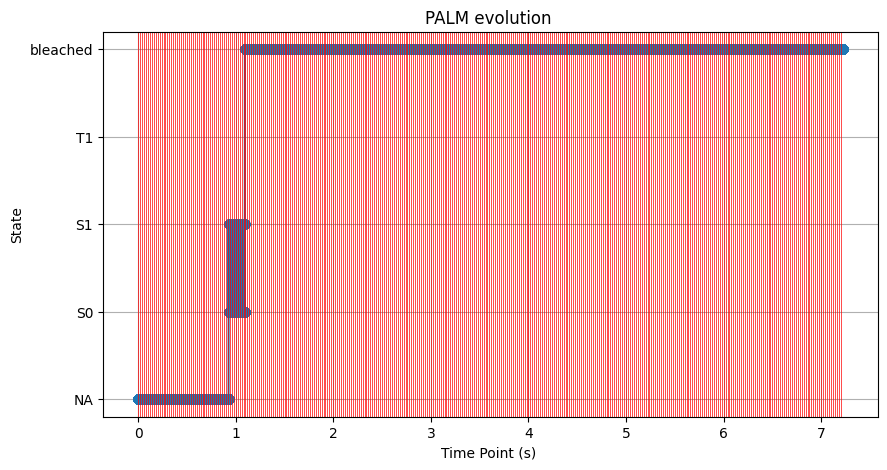

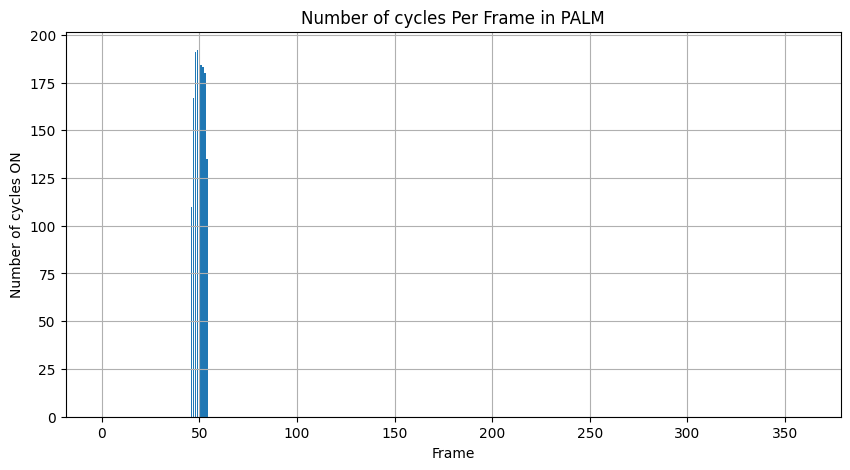

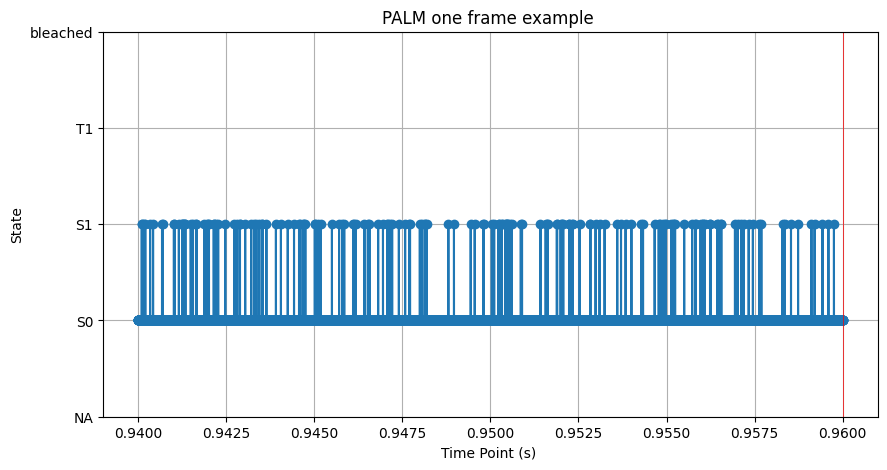

molecule 2


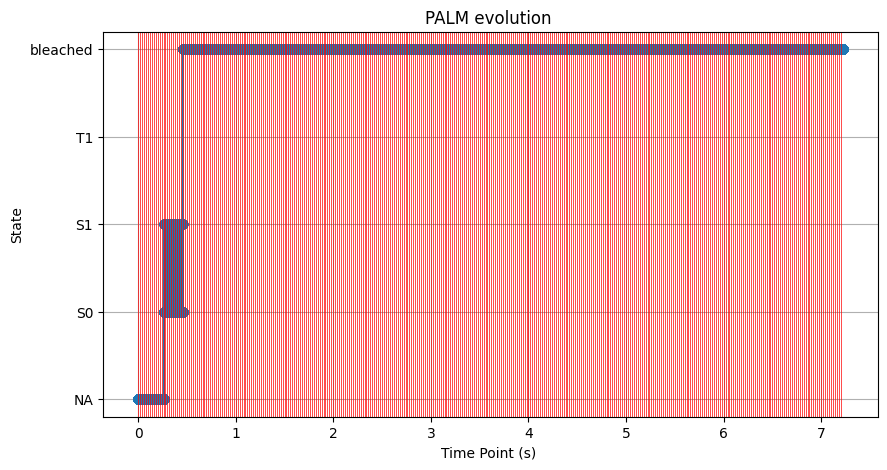

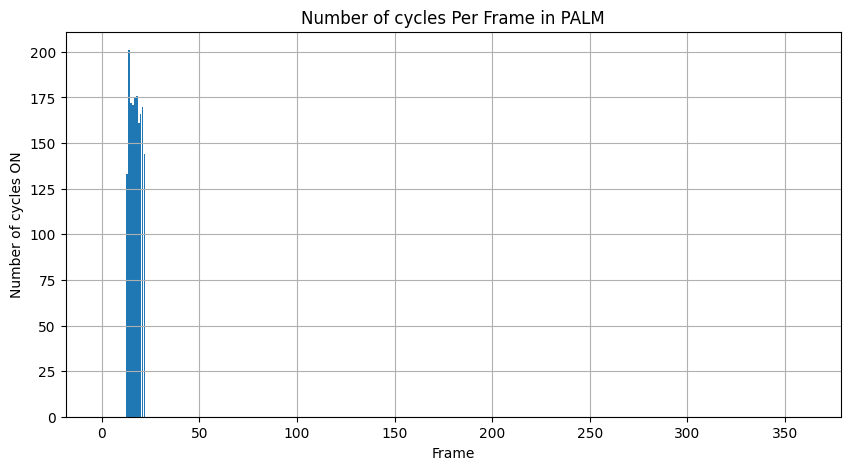

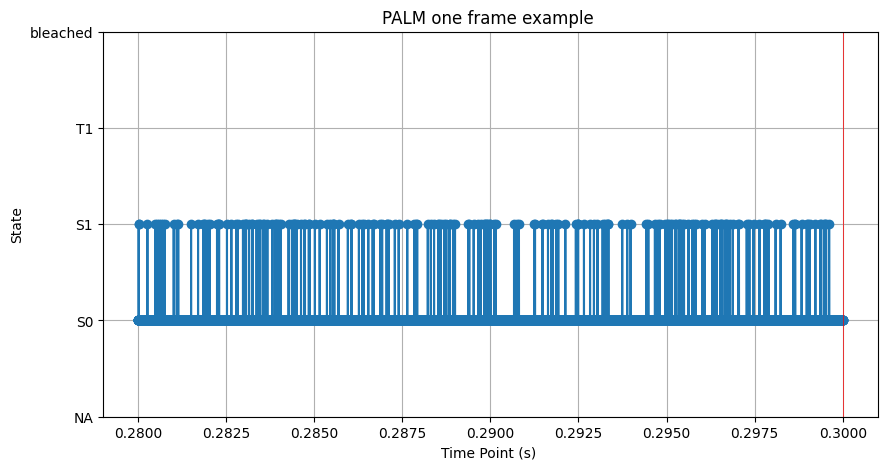

In [32]:
np.random.seed(123)
many_molecules_states =[]
for i in range(2):

    print("molecule", i+1)
    molecule_states_palm, bt,photon_count_palm = simulate_one_molecule(time_points, trans_p_palm,-1,time_discret, exposure_time, num_frames, scheme="PALM",plot_evolution=True, plot_photons=True, compute_emission=True,molecule_index=i+1)
    
    list_index_on = np.where(photon_count_palm != 0)[0]
    if len(list_index_on)>0:
        n = int((list_index_on[1])*exposure_time/time_discret)
    else:
        n=0

    time_axis = np.arange(n,n+int(exposure_time/time_discret)) * time_discret
    plt.figure(figsize=(10, 5))
    plt.plot(time_axis, molecule_states_palm[n:n+int(exposure_time/time_discret)], marker='o')
    plt.axvline(x=(n+int(exposure_time/time_discret)) * time_discret,color='red',linewidth=0.5)
    plt.xlabel('Time Point (s) ')
    plt.ylabel('State')
    plt.title(f'PALM one frame example ')
    plt.yticks([-1, 0,1, 2,3], ['NA','S0', 'S1', 'T1', 'bleached' ])
    plt.grid(True)
    plt.savefig(f"Output plot/PALM/molecule_{i+1}_zoom.png")
    plt.show()  


Comparison Metrics:
normal - Log Likelihood: -42.83, AIC: 89.66, BIC: 90.26, KL Divergence: 1.36, EMD: 5.13
laplace - Log Likelihood: -41.86, AIC: 87.73, BIC: 88.33, KL Divergence: 1.26, EMD: 7.24
poisson - Log Likelihood: -44.07, AIC: 90.15, BIC: 90.45, KL Divergence: 1.38, EMD: 4.70
geometric - Log Likelihood: -61.14, AIC: 124.29, BIC: 124.59, KL Divergence: 3.13, EMD: 129.30
binomial - Log Likelihood: -89.95, AIC: 183.91, BIC: 184.51, KL Divergence: 1.38, EMD: 8.50


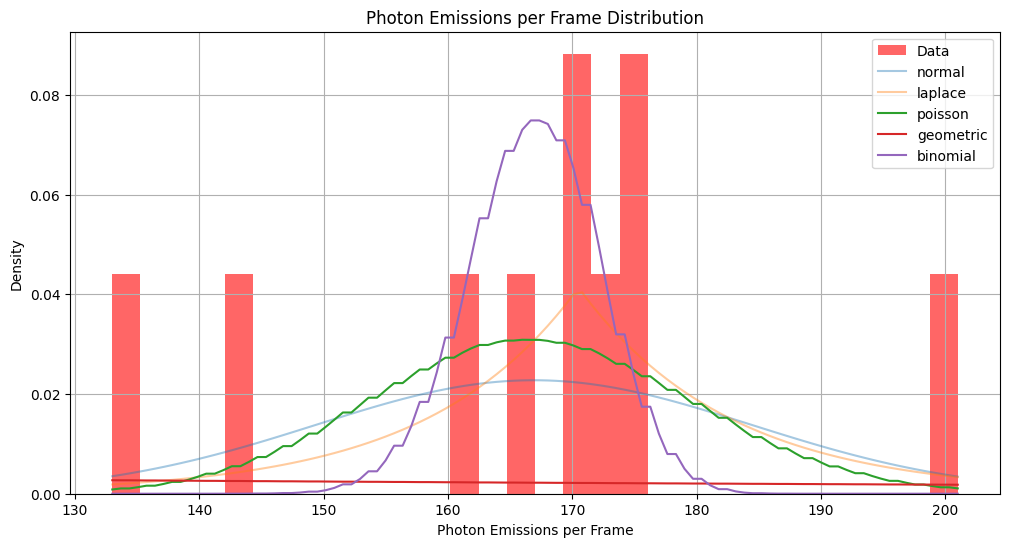

In [33]:
study_stats(photon_count_palm[photon_count_palm!=0], distributions = {'normal': stats.norm,
                                 'laplace': stats.laplace,
                                 'geometric': stats.geom,
                                 'poisson': stats.poisson,
                                 'binomial': stats.binom},plot_distribution = True,
                verbose_distribution = True)

## Fluctuations Protocol

### Single molecule Dynamics


<img src="img/FLUCTUATIONS.png" alt="STORM" style="width:400px;height:auto;"/>

 
* STORM requires the use of fluorophores capable of transitioning between prolonged (in the order of millisecond) emitting ‘on’ and non-emitting ‘off’  until eventually the fluorophore enters an irreversible photobleached state
* Since only a small fraction of the total fluorophores are emitting, it is imperative to acquire **several thousands of frames** of the observed field.
* the probability of the fluorophore to transition between the ‘on’ and the ‘off’ state can be optimised to the frame acquisition rate.
* The need for high-power laser illumination (from ∼62 to 7.8 kW/cm2)

<br>

* Start would be in T1

<br>

* We consider the transition matrix in STORM in this form 

$$
\begin{pmatrix}
0 & p_{\text{on } 0}   & 0 & 0 &0    \\
0 & p_{00} &p_{01}  & 0 & 0    \\
0 & p_{10}  & p_{11} & p_{1T} & p_{1B}     \\
0 & p_{0T}  & 0 & p_{TT} & 0     \\
0 & 0  & 0 & 0 & 1    \\
\end{pmatrix}
$$

where $ p_{ij} = \mathbb{P}(X(t_{n+1}) = j | X(t_{n}) = i )$



* Considering this time discretization $\delta = 10^{-7}s$, we will consider that the transition $S_1 \rightarrow S_0$ and $S_1 \rightarrow T$ is very fast so the probability $p_{11} = 0$ 
* We don't consider the activation probability $p_{\text{on }0} = 1 $


In [15]:
num_frames =50
exposure_time = 2e-2 #s

experiment_duration = num_frames*exposure_time #s
time_discret =1e-7 #s

time_points = int(experiment_duration//time_discret) # points

These probabilities were empirically determined to best approximate the physical transitions. Implicitly, these probabilities are proportional to the number of discrete time points.

In [16]:
p_on_0=1

p_0_1 = 4e-6
p_0_T = 0
p_0_bleach = 0

p_1_0 = 1
p_1_T = 0
p_1_bleach = 0

p_T_0 = 0
p_T_1 = 0
p_T_bleach = 0


trans_p_fluc= np.array([
    [1-p_on_0,p_on_0,0,0,0],
    [0,1-(p_0_1 +p_0_T), p_0_1 , p_0_T, p_0_bleach],
    [0,1-(p_1_T+p_1_bleach), 0, p_1_T, p_1_bleach ],
    [0,p_T_0, p_T_1, 1-(p_T_0 + p_T_1+p_T_bleach), p_T_bleach],
    [0, 0, 0, 0, 1]
])

trans_p_fluc

array([[0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 9.99996e-01, 4.00000e-06, 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]])

molecule 1


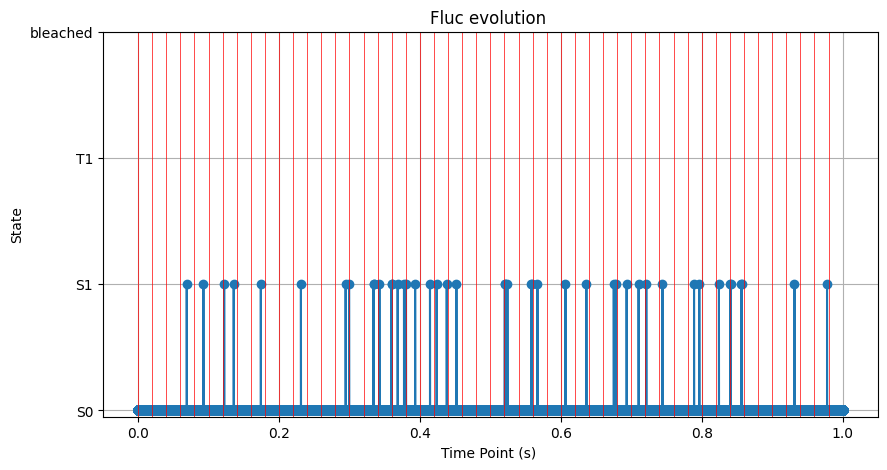

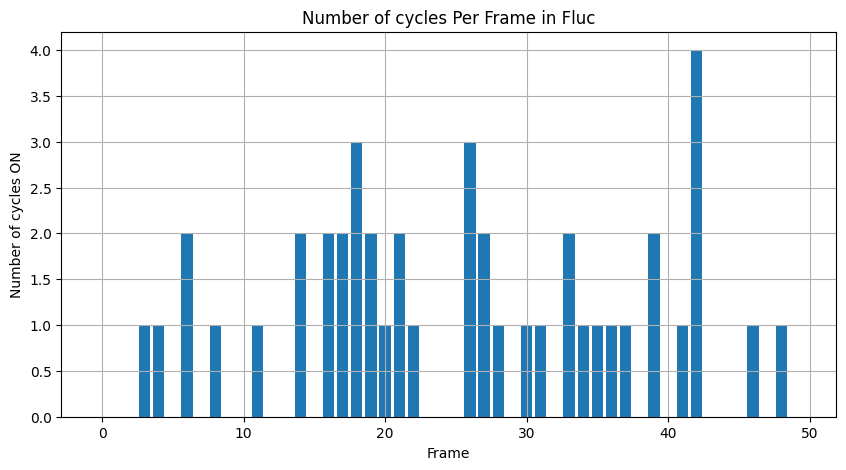

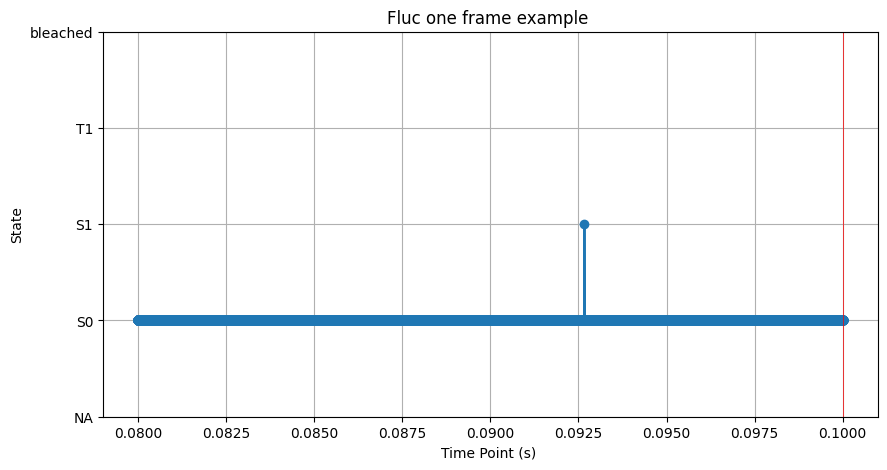

In [18]:
np.random.seed(123)
many_molecules_states =[]
for i in range(1):

    print("molecule", i+1)
    molecule_states_fluc, bt,photon_count_fluc = simulate_one_molecule(time_points, trans_p_fluc,0,time_discret, exposure_time, num_frames, scheme="Fluc",plot_evolution=True, plot_photons=True, compute_emission=True,molecule_index=i+1)
    
    list_index_on = np.where(photon_count_fluc != 0)[0]
    if len(list_index_on)>0:
        n = int((list_index_on[1])*exposure_time/time_discret)
    else:
        n=0

    time_axis = np.arange(n,n+int(exposure_time/time_discret)) * time_discret
    plt.figure(figsize=(10, 5))
    plt.plot(time_axis, molecule_states_fluc[n:n+int(exposure_time/time_discret)], marker='o')
    plt.axvline(x=(n+int(exposure_time/time_discret)) * time_discret,color='red',linewidth=0.5)
    plt.xlabel('Time Point (s) ')
    plt.ylabel('State')
    plt.title(f'Fluc one frame example ')
    plt.yticks([-1, 0,1, 2,3], ['NA','S0', 'S1', 'T1', 'bleached' ])
    plt.grid(True)
    plt.savefig(f"Output plot/Fluc/molecule_{i+1}_zoom.png")
    plt.show()  
    


Comparison Metrics:
normal - Log Likelihood: -69.55, AIC: 143.10, BIC: 146.92, KL Divergence: 1.95, EMD: 0.33
laplace - Log Likelihood: -70.94, AIC: 145.87, BIC: 149.70, KL Divergence: 2.02, EMD: 0.38
poisson - Log Likelihood: -62.62, AIC: 127.25, BIC: 129.16, KL Divergence: 7.97, EMD: 0.20
geometric - Log Likelihood: -inf, AIC: inf, BIC: inf, KL Divergence: 13.67, EMD: 0.92
binomial - Log Likelihood: -64.30, AIC: 132.60, BIC: 136.43, KL Divergence: 12.09, EMD: 0.18


/home/lenoco/Documents I3S/Fluorescence Simulation/photons_stats.py:61: RuntimeWarning: divide by zero encountered in log
  log_likelihood_geom = np.sum(np.log(stats.geom.pmf(data, p_geom)))


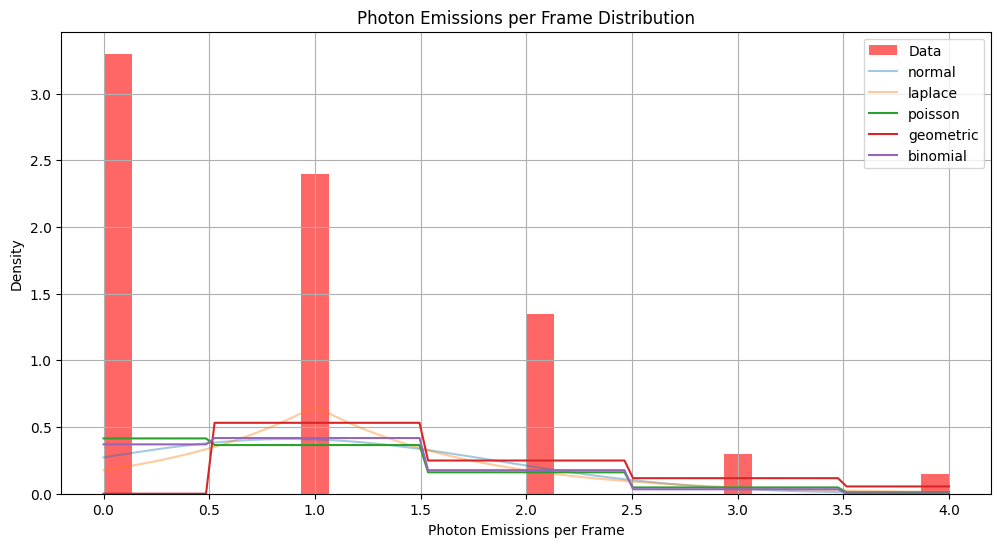

In [19]:
study_stats(photon_count_fluc, distributions = {'normal': stats.norm,
                                 'laplace': stats.laplace,
                                 'geometric': stats.geom,
                                 'poisson': stats.poisson,
                                 'binomial': stats.binom},plot_distribution = True,
                verbose_distribution = True)

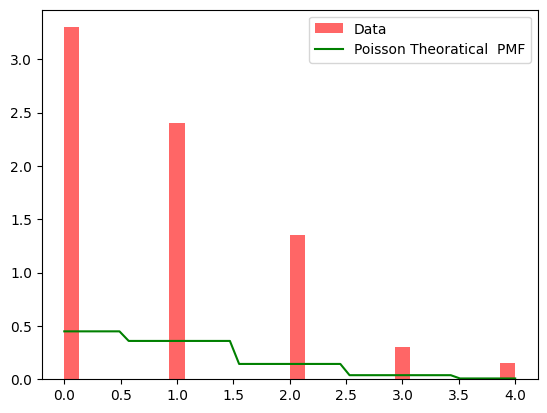

kl_div_poisson =  8.120564316107894
emd_poisson=  0.25999999999999995


In [22]:
from scipy.stats import entropy, wasserstein_distance

data = photon_count_fluc

plt.hist(data, bins=30, density=True, alpha=0.6, color='red', label='Data')
theoratical_lambda = time_points * exposure_time * p_0_1
x = np.linspace(min(data), max(data))
plt.plot(x, stats.poisson.pmf(np.round(x), theoratical_lambda), label = "Poisson Theoratical  PMF", c="g")
plt.legend()
plt.show()

poisson_rvs = stats.poisson.rvs(theoratical_lambda, size=len(data))


hist_data_poisson, _ = np.histogram(data, bins=30, density=True)
fitted_pmf_poisson = stats.poisson.pmf(np.arange(len(hist_data_poisson)), theoratical_lambda)
kl_div_poisson = entropy(hist_data_poisson + 1e-10, fitted_pmf_poisson + 1e-10)
emd_poisson = wasserstein_distance(data, poisson_rvs)


print('kl_div_poisson = ', kl_div_poisson )
print('emd_poisson= ', emd_poisson )

